# Bachelor Thesis
## MNIST classification using persistent homology

### Installs/Imports

In [1]:
!pip install giotto-tda
!pip install catboost
!pip install lightgbm
!pip install xgboost

     |████████████████████████████████| 1.5MB 3.9MB/s 
     |████████████████████████████████| 3.2MB 32.1MB/s 
     |████████████████████████████████| 13.2MB 275kB/s 
     |████████████████████████████████| 409kB 43.5MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 27.4MB 143kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 69.2MB 52kB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly as pl
from sklearn import datasets
from IPython.display import HTML

from sklearn.model_selection import train_test_split

from gtda.homology import CubicalPersistence
from gtda.images import Binarizer, RadialFiltration, DensityFiltration
from gtda.diagrams import Scaler

from gtda.diagrams import HeatKernel

from sklearn.pipeline import make_pipeline, make_union, Pipeline
from gtda.diagrams import PersistenceEntropy, Amplitude
from gtda.images import HeightFiltration
from sklearn import set_config

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### 1. Load MNIST Data and create train/test datasets

Let's load MNIST data

In [3]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [4]:
y = y.to_numpy()
X = X.to_numpy().reshape((-1, 28, 28))

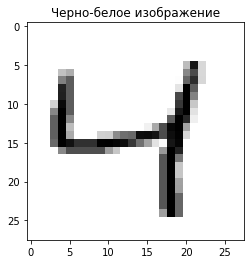

In [5]:
plt.imshow(X[2], cmap='gray_r')
plt.title("Черно-белое изображение")
plt.show()

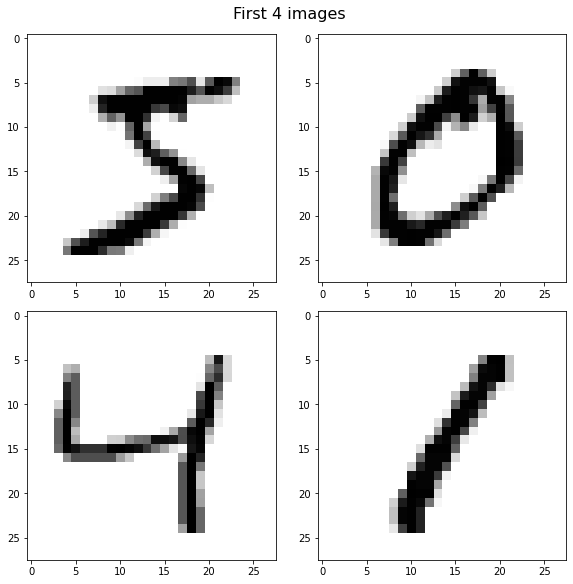

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X[i], cmap='gray_r')
fig.suptitle("First 4 images", fontsize = 16)
plt.show()

In [7]:
train_size, test_size = 700, 300


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state = 42, shuffle = True)

In [8]:
y_train.shape

(700,)

### 2. Create cubical complexes from data and extract topological features

#### 2.1 Binarization

In [ ]:
binarizer = Binarizer(threshold=0.4)

In [ ]:
X_bin = binarizer.fit_transform(X).reshape((-1, 28, 28))

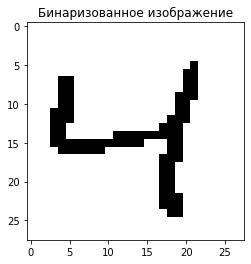

In [ ]:
plt.imshow(X_bin[2], cmap='gray_r')
plt.title("Бинаризованное изображение")
plt.show()

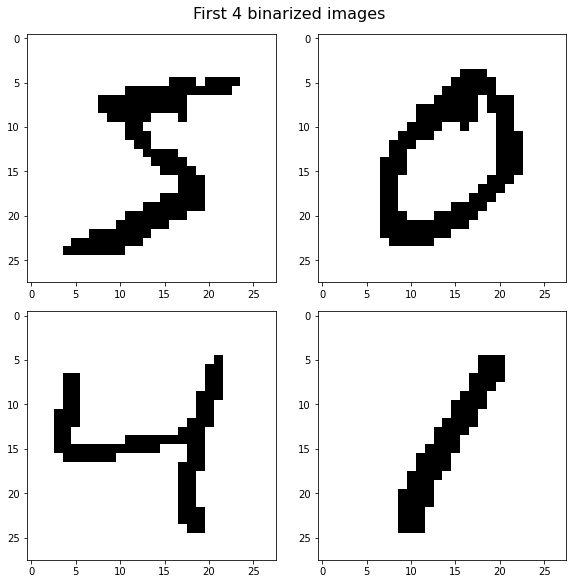

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_bin[i], cmap = 'gray_r')
fig.suptitle("First 4 binarized images", fontsize = 16)
plt.show()

#### 2.2 Filtration

In [ ]:
radial_filtration = RadialFiltration(center=np.array([20, 6]))

In [ ]:
X_filt = radial_filtration.fit_transform(X_bin).reshape((-1, 28, 28))

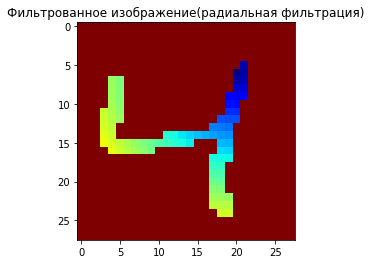

In [ ]:
plt.imshow(X_filt[2], cmap='jet')
plt.title("Фильтрованное изображение(радиальная фильтрация)")
plt.show()

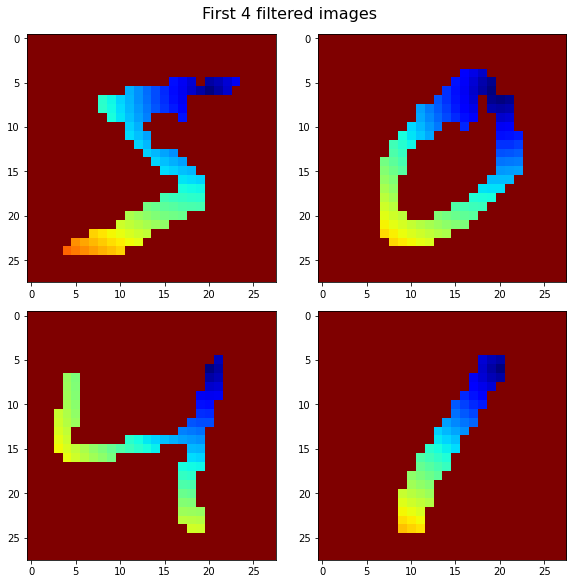

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_filt[i], cmap = "jet")
fig.suptitle("First 4 filtered images", fontsize = 16)
plt.show()

#### 2.3 Persistence

In [ ]:
cubical_persistence = CubicalPersistence(n_jobs=-1)

In [ ]:
X_pers = cubical_persistence.fit_transform(X_filt)

In [ ]:
cubical_persistence.plot(X_pers[2][None, :, :])

#### 2.4 Scaling

In [ ]:
scaler = Scaler()

In [ ]:
X_scale = scaler.fit_transform(X_pers)

In [ ]:
scaler.plot(X_scale[0][None, :, :])

### 3. Vector representation

In [ ]:
heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)

In [ ]:
X_heat = heat.fit_transform(X_scale)

In [ ]:
heat.plot(X_heat[2][None, :, :], homology_dimension_idx=0, colorscale='jet')

### 4. Creating pipeline

In [9]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

radius_list = [3, 4, 5, 6, 7, 8]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
    + [DensityFiltration(radius=r) for r in radius_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]


feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] #add features
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [10]:
X_train_tda = tda_union.fit_transform(X_train)
X_test_tda = tda_union.transform(X_test)
X_train_tda.shape

(700, 644)

### 5. Classification

Random Forest Classifier:

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

rf.score(X_test_tda, y_test)

0.8766666666666667

Logistic Regression:

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_tda, y_train)

lr.score(X_test_tda, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9033333333333333

Support Vector Machine Classifier:

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train_tda, y_train)

svc.score(X_test_tda, y_test)

0.8933333333333333

In [ ]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

LightGBM

In [ ]:
lgbm = LGBMClassifier()

lgbm.fit(X_train_tda, y_train)
lgbm.score(X_test_tda, y_test)

0.9

In [ ]:
cat = CatBoostClassifier(task_type="GPU", devices='0:1')
cat.fit(X_train_tda, y_train, verbose=False)

cat.score(X_test_tda, y_test)

0.8933333333333333

In [ ]:
xgb = XGBClassifier()

xgb.fit(X_train_tda, y_train)
xgb.score(X_test_tda, y_test)

0.8833333333333333

### 6. Tuning

#### 6.1 Feature Selection

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

print(rf.score(X_test_tda, y_test))

len(rf.feature_importances_)
#bestFeatures = rf.feature_importances_.argsort()[-250:][::-1]
#X_train_best = X_train_tda[:, bestFeatures]

0.89


644

In [ ]:
bestFeatures = rf.feature_importances_.argsort()[-200:][::-1]
X_train_best = X_train_tda[:, bestFeatures]
X_test_best = X_test_tda[:, bestFeatures]

#### 6.2 Tuning models

##### 6.2.1 Random Forest __(0.8842913563943607 for 200 features & 0.8742831639827348 for 250)__

In [ ]:
# rf_pipeline = Pipeline([
#     ('features', tda_union),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# threshold_list = [0.1, 0.4, 0.7, 0.9]
# direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
# n_estimators_list = [500, 1000, 2000]

# param_grid = {
#     #"filtration__direction": [np.array(direction) for direction in direction_list],
#     "classifier__n_estimators": [n_estimators for n_estimators in n_estimators_list],
#     'classifier__max_depth': [80, 90, 100],
#     'classifier__max_features': [2, 3, 4],
#     #'classifier__min_samples_leaf': [3, 4, 5],
#     #'classifier__min_samples_split': [8, 10, 12],
#     'classifier__n_estimators': [100, 200, 300, 1000]
# }

# grid_search = GridSearchCV(
#     estimator=rf_pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
# )

# grid_search.fit(X_train, y_train)

rf_params = {
    "n_estimators": [500, 1000, 2000],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(
    estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
)

rf_grid.fit(X_train_best, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [80, 90, 100], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=4)

In [ ]:
rf_grid.best_score_

0.8228910653803357

In [ ]:
rf_grid.best_params_

{'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

##### 6.2.2 Support Vector Machine __(0.901409828448455 for 200 features & 0.9113996796400231 for 250)__

In [ ]:
svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

svm = SVC(random_state=42)

svm_grid = GridSearchCV(
    estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
)

svm_grid.fit(X_train_best, y_train)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'coef0': [1.0, 0.0625, 0.012345679012345678, 1.0,
                                   0.125, 0.037037037037037035, 1.0, 0.25,
                                   0.1111111111111111, 1.0, 0.5,
                                   0.3333333333333333, 1.0, 1.0, 1.0],
                         'decision_function_shape': ('ovr', 'ovo'),
                         'degree': [3, 5, 7], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'sigmoid', 'rbf', 'poly')},
             verbose=4)

In [ ]:
svm_grid.best_score_

0.9113996796400231

In [ ]:
svm_grid.best_params_

{'C': 1,
 'coef0': 1.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear'}

##### 6.2.3 Logistic Regression __(0.9028526710930146 for 200 features & 0.9099874056955602 for 250)__

In [ ]:
log_params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2", "lasso"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

log = LogisticRegression()

log_grid = GridSearchCV(
    estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
)

log_grid.fit(X_train_best, y_train)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.10857391 0.47566731
 0.47566731 0.36565668 0.47566731 0.47566731        nan        nan
        nan        nan        nan        nan        nan 0.11714537
        nan 0.11714537 0.76715821 0.76715821 0.64425981 0.76715821
 0.76715821        nan        nan        nan        nan        nan
        nan        nan 0.73569691        nan 0.77999707 0.85429123
 0.85429123 0.85715246 0.85429123 0.85714635        nan        nan
        nan        nan        nan        nan        nan 0.88287297
        nan 0.87715662 0.89285059 0.89285059 0.89285671 0.88713425
 0.88714036        nan        nan        nan        nan        nan
        nan        nan 0.89571794        nan 0.89285059 0.89855471
 0.89998533 0.90855679 0.89141998 0.89142609        nan        nan
        nan        nan        nan        nan        nan 0

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'lasso'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=4)

In [ ]:
log_grid.best_score_

0.9085567905310395

In [ ]:
log_grid.best_params_

{'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}

##### 6.2.4 CatBoost __(0.89 for both)__

In [ ]:
cat = CatBoostClassifier(task_type="GPU",
                           devices='0:1');

grid = {'learning_rate': [0.003, 0.03],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.03, 0.1, 1]}

grid_search_result = cat.grid_search(grid, 
                                       X=X_train_tda, 
                                       y=y_train, 
                                       plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
13:	learn: 2.0748727	test: 2.1115838	best: 2.1115838 (13)	total: 1.06s	remaining: 1m 14s
14:	learn: 2.0605207	test: 2.0994947	best: 2.0994947 (14)	total: 1.13s	remaining: 1m 14s
15:	learn: 2.0456800	test: 2.0868171	best: 2.0868171 (15)	total: 1.2s	remaining: 1m 13s
16:	learn: 2.0311201	test: 2.0734746	best: 2.0734746 (16)	total: 1.26s	remaining: 1m 13s
17:	learn: 2.0182578	test: 2.0628669	best: 2.0628669 (17)	total: 1.33s	remaining: 1m 12s
18:	learn: 2.0047838	test: 2.0507257	best: 2.0507257 (18)	total: 1.4s	remaining: 1m 12s
19:	learn: 1.9910948	test: 2.0386536	best: 2.0386536 (19)	total: 1.47s	remaining: 1m 12s
20:	learn: 1.9780716	test: 2.0273132	best: 2.0273132 (20)	total: 1.54s	remaining: 1m 11s
21:	learn: 1.9651912	test: 2.0165750	best: 2.0165750 (21)	total: 1.62s	remaining: 1m 11s
22:	learn: 1.9524658	test: 2.0050358	best: 2.0050358 (22)	total: 1.7s	remaining: 1m 12s
23:	learn: 1.9398041	test: 1.9939560	best: 1.9939560 (23)	tota

In [ ]:
bestCat = CatBoostClassifier(**grid_search_result['params'], task_type="GPU",
                           devices='0:1')
bestCat.fit(X_train_tda, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 2.1669413	total: 60.1ms	remaining: 1m
1:	learn: 2.0288827	total: 112ms	remaining: 55.9s
2:	learn: 1.9236114	total: 151ms	remaining: 50.3s
3:	learn: 1.8235317	total: 189ms	remaining: 47s
4:	learn: 1.7382610	total: 230ms	remaining: 45.7s
5:	learn: 1.6595902	total: 266ms	remaining: 44.1s
6:	learn: 1.5852183	total: 302ms	remaining: 42.8s
7:	learn: 1.5299717	total: 334ms	remaining: 41.4s
8:	learn: 1.4724749	total: 356ms	remaining: 39.2s
9:	learn: 1.4180132	total: 379ms	remaining: 37.5s
10:	learn: 1.3634976	total: 404ms	remaining: 36.3s
11:	learn: 1.3104907	total: 428ms	remaining: 35.2s
12:	learn: 1.2641571	total: 452ms	remaining: 34.3s
13:	learn: 1.2261437	total: 477ms	remaining: 33.6s
14:	learn: 1.1818562	total: 502ms	remaining: 33s
15:	learn: 1.1439580	total: 527ms	remaining: 32.4s
16:	learn: 1.1060083	total: 560ms	remaining: 32.4s
17:	learn: 1.0727685	total: 583ms	remaining: 31.8s
18:	learn: 1.0428339	total: 606ms	remaining: 31.3s
19:	learn: 1.0176445	total: 628ms	remaining: 30

In [ ]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [ ]:
bestCat.score(X_test_tda, y_test)

0.8933333333333333

#### 6.2.5 XGBoost

In [ ]:
params = {
        'updater' : 'grow_gpu',
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier()

xgb_gridsearch = GridSearchCV(
    estimator=xgb, param_grid=params, cv=3, n_jobs=-1, verbose=4
)
xgb_gridsearch.fit(X_train_tda, y_train)
xgb_gridsearch.best_model.score(X_test_tda, y_test)

ValueError: ignored

### 7. Accuracy via number of features

In [ ]:
numOfFeatures = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 612]
accuracies = []

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

for num in numOfFeatures:
    print(num)
    bestFeatures = rf.feature_importances_.argsort()[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]
    svc_num = SVC(random_state=42)
    svc_num.fit(X_train_best, y_train)
    X_test_num = tda_union.transform(X_test)[:, bestFeatures]
    accuracies.append(svc_num.score(X_test_num, y_test))


50
100
150
200
250
300
350
400
450
500
550
600
612


In [ ]:
print(accuracies)

[0.8, 0.83, 0.7966666666666666, 0.8333333333333334, 0.8566666666666667, 0.8566666666666667, 0.8433333333333334, 0.8466666666666667, 0.8366666666666667, 0.84, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334]


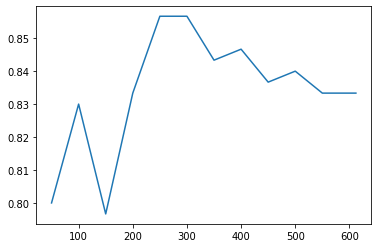

In [ ]:
plt.plot(numOfFeatures, accuracies)

In [ ]:
s = SVC(random_state=42)

X_train_part = X_train_tda[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.fit(X_train_part, y_train)

X_test_num = tda_union.transform(X_test)[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.score(X_test_num, y_test)

0.8

### 8. Grid Search with different numbers of features

In [11]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)
sortedFeatures = rf.feature_importances_.argsort()

numOfFeatures = np.arange(50, len(sortedFeatures), 50)#[50, 100, 150, 200, 250, 300, 350, 400, 450]
params = []
scores = []
accuracies = []


svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    svm = SVC(random_state=42)

    svm_grid = GridSearchCV(
        estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
    )

    svm_grid.fit(X_train_best, y_train)

    params.append(svm_grid.best_params_)
    scores.append(svm_grid.best_score_)

    X_test_num = tda_union.transform(X_test)[:, bestFeatures]
    accuracies.append(svm_grid.best_estimator_.score(X_test_num, y_test))

50
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
100
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
150
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
200
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
250
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
300
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
350
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
400
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
450
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
500
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
550
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
600
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


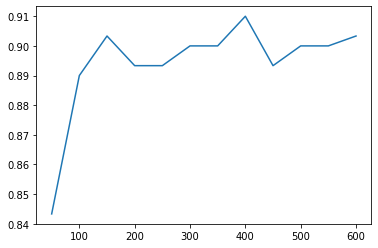

In [12]:
plt.plot(numOfFeatures, accuracies)

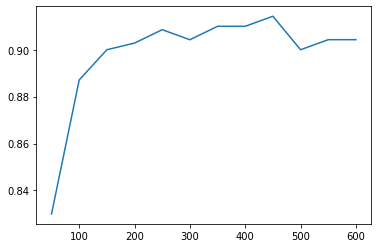

In [13]:
plt.plot(numOfFeatures, scores)

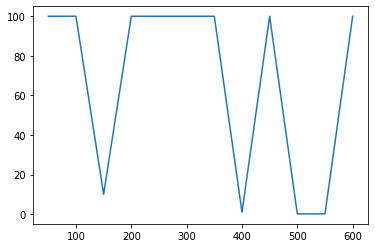

In [14]:
cs = [params[i]['C'] for i in range(len(params))]
plt.plot(numOfFeatures, cs)

### 9 Adding new features


In [ ]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
    #images.DilationFiltration
    #images.ErosionFiltration
    #images.SignedDistanceFiltration
    #images.DensityFiltration
)

diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
    #NEW FEATURES
    {"metric": "persistence_image", "metric_params": {"p": 1}}, 
    {"metric": "persistence_image", "metric_params": {"p": 2}},
    {"metric": "silhouette", "metric_params": {"p": 1}},
    {"metric": "silhouette", "metric_params": {"p": 2}}
]

feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] #add features
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-14',
                                                                                 Amplitude(metric='persistence_image',
                                                                                           metric_params={'p': 1},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-15',
                                                                                 Amplitude(metric='persistence_image',
                                                                                           metric_params={'p': 2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-16',
                                                                                 Amplitude(metric='silhouette',
                                                                                           metric_params={'p': 1},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-17',
                                                                                 Amplitude(metric='silhouette',
                                                                                           metric_params={'p': 2},
                                                                                           n_jobs=-1))]))]))])

In [ ]:
X_train_tda = tda_union.fit_transform(X_train)
X_test_tda = tda_union.transform(X_test)
X_train_tda.shape

(700, 612)

### 10. Train models without topological features

In [16]:
X_train_notop = X_train.reshape(X_train.shape[0],-1)
X_test_notop = X_test.reshape(X_test.shape[0],-1)

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_notop, y_train)

rf.score(X_test_notop, y_test)

0.8933333333333333

Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_notop, y_train)

lr.score(X_test_notop, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8833333333333333

SVC

In [ ]:
model_linear = SVC(kernel='linear')
model_linear.fit(X_train_notop, y_train)

model_linear.score(X_test_notop, y_test)

0.8733333333333333

LightGBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_notop, y_train)

lgbm.score(X_test_notop, y_test)

0.8633333333333333

CatBoost

In [ ]:
cat = CatBoostClassifier(task_type="GPU",
                           devices='0:1')
cat.fit(X_train_notop, y_train, verbose=False)

cat.score(X_test_notop, y_test)

0.89

XGBT

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_notop, y_train)

xgb.score(X_test_notop, y_test)

0.8566666666666667

### 11 Grid Search for non-topological models

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)
sortedFeatures = rf.feature_importances_.argsort()

numOfFeatures = np.arange(50, len(sortedFeatures), 50)#[50, 100, 150, 200, 250, 300, 350, 400, 450]
params_notop = []
scores_notop = []
accuracies_notop = []

svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

for num in numOfFeatures:
    print(num)
    bestFeatures = rf.feature_importances_.argsort()[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    svm = SVC(random_state=42)

    svm_grid = GridSearchCV(
        estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
    )

    svm_grid.fit(X_train_best, y_train)

    params.append(svm_grid.best_params_)
    scores.append(svm_grid.best_score_)

    X_test_num = X_test_notop[:, bestFeatures]
    accuracies.append(svm_grid.best_estimator_.score(X_test_num, y_test))

50
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
